 # Opis notatnika
 Zmierzamy do końca analizy danych, które zostały nam udostępnione. Ten krok dodaje jeszcze więcej informacji do naszego wyjściowego zbioru. Tym razem sprawdzimy między innymi to, czy opóźnienia lotów zależne są od trasy czy warunków pogodowych.

 Zanim jednak do tego przejdziemy, należy, podobnie jak w poprzednich krokach, skonfigurować odpowiednio notatnik.
 
 W tej części warsztatu ponownie wcielasz się w rolę Analiyka Danych, którego zadaniem jest wykonanie analizy eksplotacyjnej zbioru danych - jedno z wymagań dostarczonych przez klienta.

 Tutaj zaimportuj wymagane biblioteki

In [1]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from matplotlib import pyplot as plt

 ## Połączenie z bazą danych
 Tutaj uzupełnij konfigurację połączenia

In [2]:
username = 'postgres'
password = 'Wawa2023'

host = 'localhost'
database = 'airlines'
port = 5432

 Tutaj stwórz zmienną engine, która zostanie użyta do połączenia z bazą danych

In [3]:
url = f"postgresql://{username}:{password}@{host}/{database}"
engine = create_engine(url)

 Tutaj uzupełnij implementację metody `read_sql_table`

In [4]:
def read_sql_table(table_name):
    return pd.read_sql(table_name, con=engine)

 Tutaj zaczytaj zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [5]:
flight_df = pd.read_csv('../data/processed/flight_df_02.csv', sep=';', encoding='utf-8')

 # Wzbogacenie o `airport_list`
 Wczytaj do obszaru roboczego tabelę `airport_list` używając procedury `read_sql_table`. Wykonaj poniższe ćwiczenia:  
 1. Sprawdź, czy klucz `origin_airport_id` jest unikalny, tj. nie ma dwóch takich samych wartości w kolumnie `origin_airport_id`.  
 1. Jeżeli duplikaty występują, usuń je w najdogodniejszy dla Ciebie sposób.  
 1. Jeśli duplikaty nie występują, złącz ramki `airport_list_df` wraz z aktualną `flight_df`, używając kolumny `origin_airport_id` oraz złączenia typu `LEFT JOIN`. Z ramki `airport_list_df` interesuje nas dodanie kolumny `origin_city_name`.  
 1. Dodatkowo dokonaj jeszcze raz złączenia ramki `flight_df` z `airport_list_df`, tym razem jednak złącz kolumnę `destination_airport_id` wraz z `origin_airport_id`. Podobnie jak wcześniej, interesuje nas kolumna `origin_city_name`, jedank ona powinna zostać wyświetlona jako `destination_city_name`

 Tutaj wczytaj ramkę `airport_list_df`

In [6]:
airport_list_df = read_sql_table('airport_list')
airport_list_df.head()

,id,origin_airport_id,display_airport_name,origin_city_name,name
0,1,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US"
1,2,13342,General Mitchell Field,"Milwaukee, WI","MILWAUKEE MITCHELL AIRPORT, WI US"
2,3,13244,Memphis International,"Memphis, TN","MEMPHIS INTERNATIONAL AIRPORT, TN US"
3,4,15096,Syracuse Hancock International,"Syracuse, NY","SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US"
4,5,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


 Tutaj sprawdż, czy występują duplikaty dla kolumny `origin_airport_id`

In [7]:
airport_list_df['origin_airport_id'].duplicated().value_counts()

origin_airport_id
False    97
Name: count, dtype: int64

 Tutaj usuń duplikaty – jeśli występują

 Tutaj dokonaj złączenia ramki `flight_df` oraz `airport_list_df` używając `origin_airport_id`

In [8]:
flight_df = pd.merge(flight_df, airport_list_df[['origin_airport_id','origin_city_name']], on='origin_airport_id', how='left')


 Tutaj dokonaj złączenia ramki `flight_df` oraz `airport_list_df` używając `destination_airport_id`

In [9]:
flight_df = pd.merge(flight_df, airport_list_df[['origin_airport_id','origin_city_name']], left_on='dest_airport_id', right_on='origin_airport_id', how='left')
flight_df = flight_df.rename(columns={'origin_city_name_x': 'origin_city_name', 'origin_city_name_y': 'destination_city_name', 'origin_airport_id_x': 'origin_airport_id'})
flight_df.drop(columns=['origin_airport_id_y'], inplace=True)

### Sprawdzenie
Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [10]:
assert 'origin_city_name' in flight_df.columns, 'Brak kolumny `origin_city_name` w ramce flight_df'
assert 'destination_city_name' in flight_df.columns, 'Brak kolumny `destination_city_name` w ramce flight_df'

flight_df_expected_rows_amount = 1057391
assert flight_df.shape[0] == flight_df_expected_rows_amount, 'Ups, zmieniła się liczba wierszy...'

 ## Analiza według lotnisk oraz tras
 Wykonaj poniższe polecenia:  
 1. Wyznacz lotniska, z których **odlatywało** najwięcej samolotów. Wynik zapisz do ramki `top_airports_origin_df`.
 1. Wyznacz lotnika, na których najwięcej lotów **się kończyło**. Wynik zapisz do ramki `top_airports_destination_df`.  
 1. Wyznacz najczęściej uczęszczaną trasę, wynik zapisz do ramki `top_route_df`.  
 1. Przy założeniu, że reprezentatywna liczba lotów na trasie wynosi ponad 500, wyznacz dodatkowo top 10:  
     - tras z **najmniejszym odsetkiem opóźnień**, wynik zapisz do ramki `least_route_delays_df`.  
     - tras z **największym odsetkiem opóźnień**, wynik zapisz do ramki `top_route_delays_df`.

 Tutaj wyznacz ramkę `top_airports_origin_df`

In [11]:
top_airports_origin_df = flight_df.groupby('origin_city_name')['id'].count().sort_values(ascending=False)
top_airports_origin_df

origin_city_name
Atlanta, GA              123162
Chicago, IL              105437
Los Angeles, CA           87849
New York, NY              75785
Denver, CO                64525
Boston, MA                55989
Seattle, WA               50465
San Francisco, CA         50124
Dallas/Fort Worth, TX     39511
Las Vegas, NV             38456
Phoenix, AZ               36517
Burbank, CA               30565
Washington, DC            29744
Orlando, FL               26997
San Diego, CA             24912
Newark, NJ                24230
Philadelphia, PA          19595
Midland/Odessa, TX        13033
Miami, FL                 12605
Salt Lake City, UT        12428
Baltimore, MD             12102
Charlotte, NC             12047
Honolulu, HI              11232
Kahului, HI               10718
Fort Lauderdale, FL        8612
Kona, HI                   7792
Tampa, FL                  7165
Anchorage, AK              6966
Lihue, HI                  6933
Detroit, MI                6591
San Jose, CA           

 Tutaj wyznacz ramkę `top_airports_destination_df`

In [12]:
top_airports_destination_df = flight_df.groupby('destination_city_name')['id'].count().sort_values(ascending=False)
top_airports_destination_df

destination_city_name
Atlanta, GA              122945
Chicago, IL              100333
Los Angeles, CA           87776
New York, NY              75769
Denver, CO                64602
Boston, MA                56057
Seattle, WA               50230
San Francisco, CA         49999
Dallas/Fort Worth, TX     39488
Las Vegas, NV             38494
Phoenix, AZ               36499
Burbank, CA               30534
Washington, DC            29759
San Diego, CA             24926
Newark, NJ                24227
Orlando, FL               21760
Philadelphia, PA          19573
Midland/Odessa, TX        13055
Miami, FL                 12613
Salt Lake City, UT        12504
Baltimore, MD             12163
Charlotte, NC             12016
Honolulu, HI              11225
Kahului, HI               10725
Fort Lauderdale, FL        8628
Kona, HI                   7803
Anchorage, AK              7199
Tampa, FL                  7157
Lihue, HI                  6940
Detroit, MI                6619
San Jose, CA      

 ### Sprawdzenie dla `top_airport_origin`

### Sprawdzenie dla `top_airport_destination`

In [13]:
top_airports_destination_head = (top_airports_destination_df
                                 .sort_values(ascending=False)
                                 .head()
                                 .to_list()
                                 )
top_airports_destination_head = tuple(top_airports_destination_head)
top_airports_destination_head_expected = (122945, 100333, 87776, 75769, 64602)  #poprawiony bład w tescie

assert top_airports_destination_head == top_airports_destination_head_expected, f"Nie zgadza się top 5 wierszy, oczekiwano wyników: {top_airports_destination_head_expected} otrzymano: {top_airports_destination_head}"


 # Wzbogacenie o dane pogodowe
 Używając procedury `read_sql_table`, wczytaj tabelę `airport_weather` do ramki `airport_weather_df`. Następnie wykonaj następujące polecenia:  
 1. Pozostaw w ramce tylko następujące kolumny: `['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']`.  
 1. Połącz ramki `airport_list_df` wraz z `airport_weather_df` po odpowiedniej kolumnie używając takiego złączenia, aby w wyniku usunąć te wiersze (lotniska), które nie posiadają danych pogodowych. Dodatkowo, upewnij się, że zostanie tylko dodana kolumna `origin_airport_id`.

 Tutaj wczytaj ramkę `airport_weather`

In [14]:
airport_weather_df = read_sql_table('airport_weather')


 Tutaj oczyść ramkę `airport_weather_df` z nadmiarowych kolumn

In [15]:
airport_weather_df = airport_weather_df.loc[:, ['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']]


 Tutaj połącz ramki `airport_list_df` oraz `airport_weather_df` aktualizując `airport_weather_df`

In [16]:
airport_weather_df = pd.merge(airport_weather_df, airport_list_df[['name', 'origin_airport_id']], on='name', how='inner')

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [17]:
airport_weather_df_expected_shape = (43394, 9)
airport_weather_df_shape = airport_weather_df.shape

assert airport_weather_df_expected_shape == airport_weather_df_shape, \
  f'Nieodpowiedni wymiar ramki airport_weather_df, oczekiwano (wierszy, kolumn): {airport_weather_df_expected_shape}'


 ## Połączenie `airport_weather_df` oraz `flight_df`
 W celu złączenia ramek `airport_weather_df` oraz `flight_df` wykonaj następujące kroki:  
 1. w ramce `aiport_weather_df` występuje kolumna `date`, zrzutuj ją na typ `DATETIME`.  
 1. w ramce `flight_df` należy stworzyć nową kolumnę o nazwie `date`. W tym celu:  
 	- złącz kolumny `month`, `day_of_month` oraz `year` razem, użyj następującego formatu daty: `YYYY-MM-DD`.
 	- zrzutuj kolumnę `date` na typ `DATETIME`.  
 1. złącz ramki używając odpowiedniego klucza, wynik złączenia zapisz do ramki `flight_df`. Użyj złącznia typu `LEFT JOIN`.

 > Dlaczego istotne jest zachowanie typów przy złączeniu?

W trakcie pracy możesz posłużyć się następującymi artykułami z `LMS`:
 - `Python - analiza danych > Dzień 6 - Pandas > Merge`
 - `Python - analiza danych > Dzień 6 - Pandas > Praca z datetime`
 - Dokumentacje metody `to_datetime`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)
 - Dostępne formaty dat: [klik](https://www.programiz.com/python-programming/datetime/strftime) - sekcja `Format Code List`

 Tutaj zrzutuj kolumnę `date` na `DATETIME` w ramce `airport_weather_df`

In [18]:
from datetime import date

In [19]:
airport_weather_df['date'] = pd.to_datetime(airport_weather_df['date'], format='%Y-%m-%d')


 Tutaj stwórz kolumnę `date` w ramce `flight_df`. Pamiętaj, aby była ona również typu `DATETIME`.

In [20]:
flight_dates = flight_df['year'].astype(str) + '-' + flight_df['month'].astype(str) + '-' + flight_df['day_of_month'].astype(str)
flight_df['date'] = pd.to_datetime(flight_dates, format='%Y-%m-%d')

 Tutaj złącz tabeli `airport_weather_df` oraz `flight_df`

In [21]:
print(airport_weather_df.columns)
print(flight_df.columns)

Index(['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd',
       'origin_airport_id'],
      dtype='object')
Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'year', 'is_delayed', 'is_weekend',
       'distance_agg', 'manufacture_year', 'manufacture_year_agg',
       'origin_city_name', 'destination_city_name', 'date'],
      dtype='object')


In [22]:
flight_df = pd.merge(flight_df, airport_weather_df, on=['origin_airport_id','date'], how='left')


 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [23]:
flight_df_expected_rows_amount = 1057391
assert flight_df.shape[0] == flight_df_expected_rows_amount, 'Ups, zmieniła się liczba wierszy...'


# Praca samodzielna
Używając `flight_df` zbadaj hipotezę o tym, że temperatura maksymalna wpływa na **odsetek** opóźnień lotów (kolumna `tmax`).  

Przy wykonywaniu tego zadania masz pełną dowolność, jednak powinno składać się conajmniej z następujących elementów:
- sprawdzenie, czy zmienna posiada obserwacje odstające,
- oczyszczenie danych o ile konieczne,
- przedstawienie w formie tabeli czy wzrost danej zmiennej powoduje zmianę w odsetku opóźnień lotów,
- wizualizację stworzonej wcześniej tabeli w formie wykresu,
- krótkiego opisu wyników w komórce markdown.

 ## Analiza dla kolumny `tmax`

In [24]:
flight_df['tmax'].describe().round(0)

count    1051956.0
mean          70.0
std           18.0
min          -10.0
25%           59.0
50%           72.0
75%           84.0
max          115.0
Name: tmax, dtype: float64

In [25]:
flight_df_tmax_cleared = flight_df.dropna(subset=['tmax'])
flight_df_tmax_cleared['tmax'].isnull().sum()

0

In [26]:
values_count = flight_df_tmax_cleared['tmax'].value_counts(ascending=True)
vlaue_of_percentile_5 = values_count.quantile(0.05)

In [27]:
flight_df_tmax_number_of_flights = flight_df_tmax_cleared.groupby('tmax')['id'].count().sort_values(ascending=False)
tmax_number_of_flights_cleared = flight_df_tmax_number_of_flights[flight_df_tmax_number_of_flights > vlaue_of_percentile_5]
tmax_number_of_flights_cleared

tmax
67.0     26785
75.0     25499
73.0     25361
72.0     24557
89.0     24314
         ...  
13.0       307
113.0      300
5.0        295
14.0       233
16.0       219
Name: id, Length: 106, dtype: int64

In [28]:
flight_tmax_delays_df = flight_df_tmax_cleared[flight_df_tmax_cleared['tmax'].isin(tmax_number_of_flights_cleared.index)].groupby('tmax')['is_delayed'].mean()
flight_tmax_delays_df.to_frame()


,is_delayed
tmax,
5.0,0.477966
10.0,0.369748
11.0,0.224684
12.0,0.267164
13.0,0.273616
...,...
110.0,0.190940
111.0,0.168142
112.0,0.164619


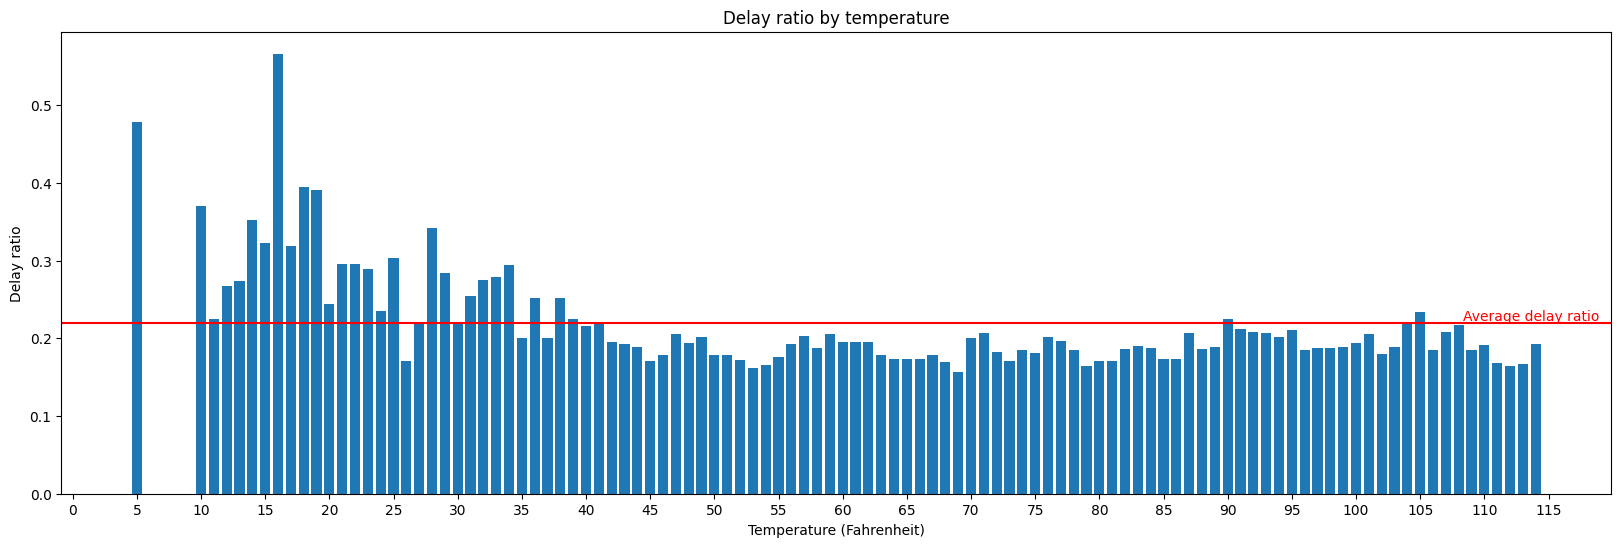

In [51]:
plt.figure(figsize=(20, 6))
plt.bar(flight_tmax_delays_df.index, flight_tmax_delays_df)
plt.xticks(np.arange(0, 120, 5))
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Delay ratio")
plt.title("Delay ratio by temperature")
plt.axhline(y=flight_tmax_delays_df.mean(), color='r', linestyle='-')
plt.text(119, flight_tmax_delays_df.mean(), 'Average delay ratio' ,ha='right', va='bottom', color='r')
plt.show()

### Z danych wynika, że im nizsza temperatura tym opóźnienie w starcie samolotu jest większe. Prawdopodbnie zwiazane jest to z dodatkowymi czynnościami obsługowymi jak np odladzanie.

# Podsumowanie
W tej części warsztatu dokonaliśmy kompleksowej analizy posiadanego zbioru danych. Eksploracja
pozwoliła nam na zapoznanie się z cechami charakterystycznymi lotów - wiemy już, które 
zmienne mogą mieć wpływ na opóźnienia lotów, a które nie. Co warto podkreślić, skupiliśmy się na wielu
aspektach tej analizy, co otwiera potencjalnie również inne możliwości dalszej pracy nad tą bazą.

W tym momencie przejdziemy do kolejnego kroku, w którym, na podstawie tej analizy, przygotujemy 
system raportowy. Zanim jednak stworzymy dashboard, potrzebujemy zaktualizować naszą bazę danych.